# The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. The dataset and more information can be founded [`here`](http://ufldl.stanford.edu/housenumbers/).

## Loading libraries

In [2]:
import os
import time
import pickle
import numpy as np
import tensorflow as tf
from __future__ import print_function
from tqdm import tqdm
from urllib import urlretrieve
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

from helpers import display_sample_images, preprocess_images, one_hot_encode, batch_creator

%matplotlib inline
tf.reset_default_graph()

## Loading VGG-16 trained model

In [3]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('./tensorflow_vgg/vgg16.npy'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            './tensorflow_vgg/vgg16.npy',
            pbar.hook)

from tensorflow_vgg import vgg16
print('Model loaded!')

Model loaded!


## Load the dataset

In [4]:
if not os.path.isfile('../data/train_32x32.mat'):
    os.mkdir('../data')
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Dataset') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            '../data/train_32x32.mat',
            pbar.hook)

svhn_data = loadmat('../data/train_32x32.mat')
print('Data loaded!')

Data loaded!


## Understanding the dataset

In [5]:
print(type(svhn_data))
print(svhn_data.keys())

<type 'dict'>
['y', 'X', '__version__', '__header__', '__globals__']


In [6]:
features = svhn_data['X']
labels = svhn_data['y']

print('X: {} ({} x {} x {}) images'.format(features.shape[3], features.shape[0],
                                           features.shape[1], features.shape[2]))
print('y: {} ({}) labels'.format(labels.shape[0], labels.shape[1]))
print('First 30 labels: {}'.format(labels[:30].reshape((1,-1))))
print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

X: 73257 (32 x 32 x 3) images
y: 73257 (1) labels
First 30 labels: [[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8 1 6 2 3 6 3 4 2 5 8]]
Label Counts: {1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


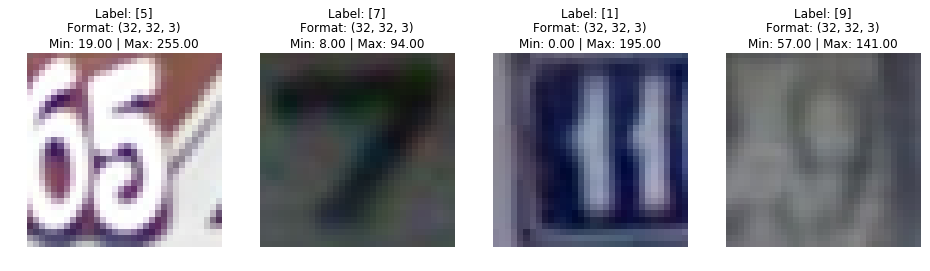

In [7]:
display_sample_images(features, labels, 4)

## Transfering learning (using a trained net)

In [7]:
if not os.path.isfile('./code_data.pkl'):
    batch_size = 8
    codes = None
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        images = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope('content_vgg'):
            vgg.build(images)
    
        for batch, _ in tqdm(batch_creator(features, labels, batch_size), desc='Training'):
            processed_batch = preprocess_images(batch)
            feed_dict = {images: processed_batch}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
        
    with open('./code_data.pkl', 'wb') as f:
        pickle.dump(codes, f)

## Preporcessing part trained data

In [8]:
with open('./code_data.pkl', 'rb') as f:
    codes = pickle.load(f)
print(codes.shape)

(73257, 4096)


In [10]:
one_hot_labels = one_hot_encode(labels)
print(one_hot_labels.shape)

(73257, 10)


In [ ]:
train_size = 0.6
idx = np.random.shuffle(list(range(codes.shape[0])))
split_point = int(codes.shape[0] * train_size)
train_idx = idx[:split_point]
test_idx = idx[split_point:]

In [8]:
X_train = codes[train_idx]
y_train = one_hot_labels[train_idx]
X_test = codes[test_idx]
y_test = one_hot_labels[test_idx]

print('Train features: {} | Test features: {}'.format(X_train.shape, X_test.shape))
print('Train labels:   {}   | Test labels:   {}'.format(y_train.shape, y_test.shape))

NameError: name 'codes' is not defined

## Building the Neural Net

In [12]:
def fully_conn(x_tensor, num_outputs, activation=False):
    W = tf.Variable(tf.truncated_normal([int(x_tensor.get_shape()[1]),num_outputs], stddev=0.1))
    b = tf.Variable(tf.zeros([num_outputs]))
    net = tf.matmul(x_tensor, W) + b
    if activation:
        net = tf.nn.relu(net)
    return net

In [13]:
inputs_ = tf.placeholder(tf.float32, [None, codes.shape[1]])
labels_ = tf.placeholder(tf.float32, [None, one_hot_labels.shape[1]])
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

with tf.name_scope('fully_conn_content'):
    # continues the VGG16 architecture
    relu6 = tf.nn.relu(inputs_)
    drop6 = tf.nn.dropout(relu6, keep_prob)
    fc7 = fully_conn(drop6, 4096, True)
    drop7 = tf.nn.dropout(fc7, keep_prob)
    logits = fully_conn(drop7, one_hot_labels.shape[1])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_), name='cost')

with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Trainning the model

In [14]:
epochs = 300
batch_size = 10240
val_size = 0.2
learn_rate = 0.01
keep_probability = 0.5
display_epoch = 10

In [16]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        i = 0
        train_total_loss = 0
        train_total_acc = 0
        val_total_loss = 0
        val_total_acc = 0
        for feat_train, feat_val, lab_train, lab_val in batch_creator(X_train, y_train, batch_size, val_size, flatted=True):
            train_dict = {inputs_: feat_train,
                          labels_: lab_train,
                          learning_rate: learn_rate,
                          keep_prob: keep_probability
                         }
            sess.run(optimizer, feed_dict = train_dict)
            train_loss, train_acc = sess.run([cost, accuracy], feed_dict = train_dict)
            train_total_loss += train_loss
            train_total_acc += train_acc
            
            val_dict = {inputs_: feat_val,
                        labels_: lab_val,
                        keep_prob: 1.0
                       }
            val_loss, val_acc = sess.run([cost, accuracy], feed_dict = val_dict)
            val_total_loss += val_loss
            val_total_acc += val_acc
            
            i += 1
        
        train_loss_list.append(train_total_loss / (i + 1))
        train_acc_list.append(train_total_acc / (i + 1))
        val_loss_list.append(val_total_loss / (i + 1))
        val_acc_list.append(val_total_acc / (i + 1))
        if epoch % display_epoch == 0 or epoch + 1 == epochs:
            output = 'Epoch {:4d}/{:4d} | Train loss {:.4f} | Train acc {:.4f} | Val loss {:.4f} | Val acc {:.4f}'
            print(output.format(epoch,
                                epochs,
                                train_total_loss / (i + 1),
                                train_total_acc / (i + 1),
                                val_total_loss / (i + 1),
                                val_total_acc / (i + 1)
                               ))
            
    
    if not os.path.isdir('./checkpoints'):
        !mkdir ./checkpoints
    saver.save(sess, "./checkpoints/svhn.ckpt")

Epoch   0 / 300 | Train loss 14518.985 | Val loss 14546.896
Epoch  10 / 300 | Train loss 5.286 | Val loss 5.206
Epoch  20 / 300 | Train loss 1.876 | Val loss 1.876
Epoch  30 / 300 | Train loss 1.867 | Val loss 1.867
Epoch  40 / 300 | Train loss 1.865 | Val loss 1.862
Epoch  50 / 300 | Train loss 1.864 | Val loss 1.863
Epoch  60 / 300 | Train loss 1.864 | Val loss 1.860
Epoch  70 / 300 | Train loss 1.863 | Val loss 1.863
Epoch  80 / 300 | Train loss 1.863 | Val loss 1.862
Epoch  90 / 300 | Train loss 1.863 | Val loss 1.864
Epoch 100 / 300 | Train loss 1.863 | Val loss 1.862
Epoch 110 / 300 | Train loss 1.864 | Val loss 1.859
Epoch 120 / 300 | Train loss 1.864 | Val loss 1.860
Epoch 130 / 300 | Train loss 1.864 | Val loss 1.862
Epoch 140 / 300 | Train loss 1.863 | Val loss 1.865
Epoch 150 / 300 | Train loss 1.862 | Val loss 1.867
Epoch 160 / 300 | Train loss 1.863 | Val loss 1.862
Epoch 170 / 300 | Train loss 1.864 | Val loss 1.860
Epoch 180 / 300 | Train loss 1.862 | Val loss 1.866
Epoc

## Test

In [1]:
sample_image = np.random.randint(0, len(X_test))
display_sample_images(X_test, y_test, 4, test_data=sample_image)

NameError: name 'np' is not defined

In [ ]:
with tf.Session() as sess:
    val_dict = {inputs_: X_test[sample_image],
                labels_: y_test[sample_image],
                keep_prob: 1.0
               }
    prediction = sess.run(predicted, feed_dict=test_dict)
print('Predicted: {:2d}'.format(np.argmax(prediction, 1) + 1))